# Return Prediction for View and Uncertainty Matrix

In [159]:
!git clone https://github.com/GabbyLiu/Financial-Performance-Prediction.git

Cloning into 'Financial-Performance-Prediction'...
remote: Enumerating objects: 381, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 381 (delta 38), reused 88 (delta 12), pack-reused 242
Receiving objects: 100% (381/381), 33.90 MiB | 24.22 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [164]:
%cd Financial-Performance-Prediction.git

[Errno 2] No such file or directory: 'Financial-Performance-Prediction.git'
/content


In [138]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Function to preprocess data
def preprocess_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df['Future_Return'] = df['Close'].shift(-100) / df['Close'] - 1
    df = df.dropna(subset=['Future_Return'])
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df = df.dropna()
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5']
    X = df[features]
    y = df['Future_Return']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y

# Function to train models and perform bootstrapping
def train_and_predict(X_train, y_train, X_test, n_iterations=100):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1, max_depth=5, alpha=10, n_estimators=100)
    }
    predictions = {}

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        preds = np.zeros((n_iterations, X_test.shape[0]))
        for i in range(n_iterations):
            preds[i] = model.predict(X_test)
        predictions[model_name] = preds.mean(axis=0)

    return predictions

# Load data for three companies
company_files = ['/content/brookfield_renewable_partners_stock_data.csv', '/content/enphas_energy_stock_data.csv', '/content/first_solar_stock_data.csv']
companies_data = [pd.read_csv(file) for file in company_files]

# Preprocess data and split into training and testing sets
split_ratio = 0.8
data_splits = []
for df in companies_data:
    X, y = preprocess_data(df)
    train_size = int(len(X) * split_ratio)
    data_splits.append((X[:train_size], X[train_size:], y[:train_size], y[train_size:]))

# Initialize matrices to store results
n_companies = len(companies_data)
n_models = 3
returns_matrix = np.zeros((n_companies, n_models))
confidence_intervals_matrix = np.zeros((n_companies, n_models, 2))  # lower and upper bounds
uncertainty_matrix = np.zeros((n_companies, n_models))

# Train models and calculate predictions
predicted_returns = []
for i, (X_train, X_test, y_train, y_test) in enumerate(data_splits):
    predictions = train_and_predict(X_train, y_train, X_test)
    uncertainties = train_and_predict(X_train, y_train, X_test)
    predicted_returns.append(predictions)

    # Store predictions
    returns_matrix[i, 0] = predictions['Linear Regression'].mean()
    returns_matrix[i, 1] = predictions['Random Forest'].mean()
    returns_matrix[i, 2] = predictions['XGBoost'].mean()

    # Store confidence intervals (95% CI)
    confidence_intervals_matrix[i, 0, 0] = predictions['Linear Regression'].mean() - 1.96 * uncertainties['Linear Regression'].mean()
    confidence_intervals_matrix[i, 0, 1] = predictions['Linear Regression'].mean() + 1.96 * uncertainties['Linear Regression'].mean()
    confidence_intervals_matrix[i, 1, 0] = predictions['Random Forest'].mean() - 1.96 * uncertainties['Random Forest'].mean()
    confidence_intervals_matrix[i, 1, 1] = predictions['Random Forest'].mean() + 1.96 * uncertainties['Random Forest'].mean()
    confidence_intervals_matrix[i, 2, 0] = predictions['XGBoost'].mean() - 1.96 * uncertainties['XGBoost'].mean()
    confidence_intervals_matrix[i, 2, 1] = predictions['XGBoost'].mean() + 1.96 * uncertainties['XGBoost'].mean()

    # Calculate uncertainty as the width of the confidence interval
    uncertainty_matrix[i, 0] = confidence_intervals_matrix[i, 0, 1] - confidence_intervals_matrix[i, 0, 0]
    uncertainty_matrix[i, 1] = confidence_intervals_matrix[i, 1, 1] - confidence_intervals_matrix[i, 1, 0]
    uncertainty_matrix[i, 2] = confidence_intervals_matrix[i, 2, 1] - confidence_intervals_matrix[i, 2, 0]




<ipython-input-138-adcf1e79226a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA_5'] = df['Close'].rolling(window=5).mean()
<ipython-input-138-adcf1e79226a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA_200'] = df['Close'].rolling(window=200).mean()
<ipython-input-138-adcf1e79226a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [144]:
import yfinance as yf
import pandas as pd

# Define the stock tickers
tickers = ['BN', 'ENPH', 'FSLR']  # Example tickers for Apple, Google, and Microsoft

# Download historical data for each stock
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start="2021-12-31", end="2024-07-01")[['Open', 'Close']]

# Combine the data into a single DataFrame
df_combined = pd.DataFrame()
for ticker in tickers:
    df_temp = data[ticker].copy()
    df_temp.columns = [f'{ticker}_Open', f'{ticker}_Close']
    df_combined = pd.merge(df_combined, df_temp, left_index=True, right_index=True, how='outer')

# Add a sample risk-free rate (e.g., 1% per year, constant)
df_combined['RiskFreeRate'] = 0.02

# Save the combined DataFrame to a CSV file
df_combined.to_csv('combined_stock_data.csv')

# Display the combined DataFrame
print(df_combined.head())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

              BN_Open   BN_Close   ENPH_Open  ENPH_Close  FSLR_Open  \
Date                                                                  
2021-12-31  48.932903  48.811642  186.899994  182.940002  87.500000   
2022-01-03  48.811642  48.464027  185.229996  184.449997  88.010002   
2022-01-04  48.504444  48.924816  187.589996  178.279999  91.199997   
2022-01-05  49.094585  46.709782  174.559998  157.199997  87.300003   
2022-01-06  46.685532  46.523849  156.009995  151.490005  83.010002   

            FSLR_Close  RiskFreeRate  
Date                                  
2021-12-31   87.160004          0.02  
2022-01-03   88.580002          0.02  
2022-01-04   87.279999          0.02  
2022-01-05   83.510002          0.02  
2022-01-06   83.970001          0.02  


In [152]:
assets = ['BN_Close', 'ENPH_Close', 'FSLR_Close']
for asset in assets:
    df_combined[f'{asset}_Return'] = df_combined[asset].pct_change()
# Calculate daily return for the risk-free rate
df_combined['RiskFreeRate_Return'] = df_combined['RiskFreeRate'].pct_change()

# Drop NaN values
df_combined.dropna(inplace=True)

# Select return columns
return_columns = [f'{asset}_Return' for asset in assets]
returns = df_combined[return_columns]

print(df_combined.head())

              BN_Open   BN_Close   ENPH_Open  ENPH_Close  FSLR_Open  \
Date                                                                  
2022-01-06  46.685532  46.523849  156.009995  151.490005  83.010002   
2022-01-07  46.564266  46.378334  152.110001  145.130005  83.440002   
2022-01-10  46.014549  45.820534  140.210007  147.130005  83.019997   
2022-01-11  45.877121  47.421181  145.919998  148.509995  84.470001   
2022-01-12  47.736458  47.663704  150.520004  149.279999  85.139999   

            FSLR_Close  RiskFreeRate  BN_Close_Return  ENPH_Close_Return  \
Date                                                                       
2022-01-06   83.970001          0.02        -0.003981          -0.036323   
2022-01-07   84.680000          0.02        -0.003128          -0.041983   
2022-01-10   84.300003          0.02        -0.012027           0.013781   
2022-01-11   84.449997          0.02         0.034933           0.009379   
2022-01-12   84.120003          0.02         0

In [142]:
def calculate_sharpe_ratio_portfolio(returns, weights, risk_free_rate = 0.02, periods_per_year=252):
    """
    Calculate the Sharpe Ratio for a portfolio of assets.

    Parameters:
    returns (pd.DataFrame): DataFrame of daily returns of the assets.
    weights (np.array): Array of portfolio weights.
    risk_free_rate (float): Risk-free rate, expressed as an annualized rate.
    periods_per_year (int): Number of periods per year (252 for daily returns).

    Returns:
    tuple: The portfolio's volatility and Sharpe Ratio.
    """
    # Calculate the mean and covariance of daily returns
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    # Calculate the portfolio return and volatility
    portfolio_return = np.dot(weights, mean_returns) * periods_per_year
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(periods_per_year)

    # Calculate the annualized risk-free rate per period
    risk_free_rate_per_period = (1 + risk_free_rate) ** (1 / periods_per_year) - 1

    # Calculate the excess return
    excess_return = portfolio_return - risk_free_rate

    # Calculate the Sharpe Ratio
    sharpe_ratio = excess_return / portfolio_volatility

    return portfolio_volatility, sharpe_ratio



In [124]:
# Display results
print("Returns Matrix:")
print(returns_matrix)


linear_regression_returns = returns_matrix[:, 0].tolist()
print("Linear Regression Returns:", linear_regression_returns)

random_forest_returns = returns_matrix[:, 1].tolist()
print("Random Forest Returns:", linear_regression_returns)

xg_boost_returns = returns_matrix[:, 2].tolist()
print("XG Boost Returns:", linear_regression_returns)


Returns Matrix:
[[ 0.05646773  0.05948358 -0.01142377]
 [-0.09849078  0.11675507 -0.17856692]
 [ 0.20393049  0.21682116  0.12975932]]
Linear Regression Returns: [0.056467727554872026, -0.09849077523749597, 0.20393049386227663]
Random Forest Returns: [0.056467727554872026, -0.09849077523749597, 0.20393049386227663]
XG Boost Returns: [0.056467727554872026, -0.09849077523749597, 0.20393049386227663]


In [125]:
# Prepare results for output
results = {'Linear Regression': [], 'Random Forest': [], 'XGBoost': []}
uncertainty_results = {'Linear Regression': [], 'Random Forest': [], 'XGBoost': []}

for model_index, model_name in enumerate(results.keys()):
    for company_index in range(n_companies):
        results[model_name].append(returns_matrix[company_index, model_index])
        uncertainty_results[model_name].append(uncertainty_matrix[company_index, model_index])
for model_name in results:
    results[model_name] = [round(num, 2) for num in results[model_name]]
#this result is the viewDict
print(results)

for model_name in uncertainty_results:
    uncertainty_results[model_name] = [round(num, 1) for num in uncertainty_results[model_name]]
print("uncertainty")
print(uncertainty_results)



# Convert results to DataFrame and display
results_df = pd.DataFrame(results, index=['BN', 'ENPH', 'FSLR'])
print(results_df)

uncertainty_df = pd.DataFrame(uncertainty_results, index=['BN', 'ENPH', 'FSLR'])
print(uncertainty_df)


{'Linear Regression': [0.06, -0.1, 0.2], 'Random Forest': [0.06, 0.12, 0.22], 'XGBoost': [-0.01, -0.18, 0.13]}
uncertainty
{'Linear Regression': [0.2, -0.4, 0.8], 'Random Forest': [0.2, 0.5, 0.8], 'XGBoost': [-0.0, -0.7, 0.5]}
      Linear Regression  Random Forest  XGBoost
BN                 0.06           0.06    -0.01
ENPH              -0.10           0.12    -0.18
FSLR               0.20           0.22     0.13
      Linear Regression  Random Forest  XGBoost
BN                  0.2            0.2     -0.0
ENPH               -0.4            0.5     -0.7
FSLR                0.8            0.8      0.5


In [126]:
#ViewDict for Black-LItterman
# for viewDict dictionary
# exmaple
'''viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}
'''
# Using Linear Regression model

linear_regression_returns_viewDict = results_df['Linear Regression'].to_dict()
print(linear_regression_returns_viewDict)

rf_returns_viewDict = results_df['Random Forest'].to_dict()
print(rf_returns_viewDict)

xg_returns_viewDict = results_df['XGBoost'].to_dict()
print(xg_returns_viewDict)



{'BN': 0.06, 'ENPH': -0.1, 'FSLR': 0.2}
{'BN': 0.06, 'ENPH': 0.12, 'FSLR': 0.22}
{'BN': -0.01, 'ENPH': -0.18, 'FSLR': 0.13}


In [154]:
print(results_df['Linear Regression'].tolist())

[0.06, -0.1, 0.2]


In [158]:
lr_weights = np.array(results_df['Random Forest'].tolist())
portfolio_volatility, sharpe_ratio = calculate_sharpe_ratio_portfolio(returns,lr_weights, 0.02)
print(f"Portfolio Volatility: {portfolio_volatility:.4f}")
print(f"Sharpe Ratio for the portfolio: {sharpe_ratio:.4f}")

Portfolio Volatility: 0.1847
Sharpe Ratio for the portfolio: 0.5541


In [127]:
#uncertainty matrix
'''confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7,
    0.5,
    0.1,
    0.4
]
'''

linear_regression_confidences = uncertainty_df['Linear Regression'].to_list()
print(linear_regression_confidences)

rf_confidences = uncertainty_df['Random Forest'].to_list()
print(rf_confidences)

xgboost_confidences = uncertainty_df['XGBoost'].to_list()
print(xgboost_confidences)


[0.2, -0.4, 0.8]
[0.2, 0.5, 0.8]
[-0.0, -0.7, 0.5]


# Portfolio Optimization


In [73]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.4 MB/s eta 0:00:00


In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pypfopt import EfficientFrontier, risk_models, black_litterman, expected_returns, BlackLittermanModel, HRPOpt, CLA

In [103]:
tickers = ["BN", "ENPH", "FSLR"]
ohlc = yf.download(tickers, start='2022-01-01',end='2024-01-01')
prices = ohlc["Adj Close"]
prices.head()

[*********************100%%**********************]  3 of 3 completed


Ticker,BN,ENPH,FSLR
Date,,,
2022-01-03,47.336155,184.449997,88.580002
2022-01-04,47.786217,178.279999,87.279999
2022-01-05,45.622734,157.199997,83.510002
2022-01-06,45.441132,151.490005,83.970001
2022-01-07,45.299004,145.130005,84.680000


In [104]:
market_prices = yf.download("SPY", start='2022-01-01',end='2024-01-01')["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2022-01-03,460.127380
2022-01-04,459.973236
2022-01-05,451.140778
2022-01-06,450.716919
2022-01-07,448.935059


In [105]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

0.3203774055766275

In [106]:
daily_returns = prices.pct_change().dropna()
mu = expected_returns.mean_historical_return(prices)
daily_returns.head()

Ticker,BN,ENPH,FSLR
Date,,,
2022-01-04,0.009508,-0.033451,-0.014676
2022-01-05,-0.045274,-0.118241,-0.043194
2022-01-06,-0.003981,-0.036323,0.005508
2022-01-07,-0.003128,-0.041983,0.008455
2022-01-10,-0.012027,0.013781,-0.004487


In [107]:
def deviation_risk_parity(w, cov_matrix):
    diff = w * np.dot(cov_matrix, w) - (w * np.dot(cov_matrix, w)).reshape(-1, 1)
    return (diff**2).sum().sum()

In [108]:
ef = EfficientFrontier(mu, S)
weights = ef.nonconvex_objective(deviation_risk_parity, ef.cov_matrix)
ef.portfolio_performance(verbose=True)

Expected annual return: 4.4%
Annual volatility: 37.4%
Sharpe Ratio: 0.06


(0.043992958663700205, 0.3739743722613978, 0.064156692124694)

**Black-Litterman**

In [109]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'BN': 70283501568, 'ENPH': 14245040128, 'FSLR': 22805827584}

In [110]:
prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

In [128]:
#linear regression viewDict
#linear_regression_returns_viewDict
#rf_returns_viewDict
#xg_returns_viewDict
bl = BlackLittermanModel(S, pi=prior, absolute_views=linear_regression_returns_viewDict)
rets = bl.bl_returns()
ef = EfficientFrontier(rets, S)
ef.max_sharpe()
print(ef.clean_weights())
ef.portfolio_performance(verbose=True)


OrderedDict([('BN', 0.36238), ('ENPH', 0.0), ('FSLR', 0.63762)])
Expected annual return: 8.4%
Annual volatility: 39.5%
Sharpe Ratio: 0.16


(0.0835746557960745, 0.39508397336938905, 0.16091428678792424)

**Hierarchical risk parity**

Expected annual return: 7.2%
Annual volatility: 33.6%
Sharpe Ratio: 0.16
OrderedDict([('BN', 0.706333186384893), ('ENPH', 0.11260488835151905), ('FSLR', 0.181061925263588)])


/usr/local/lib/python3.10/dist-packages/pypfopt/hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.70633319]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


<Axes: >

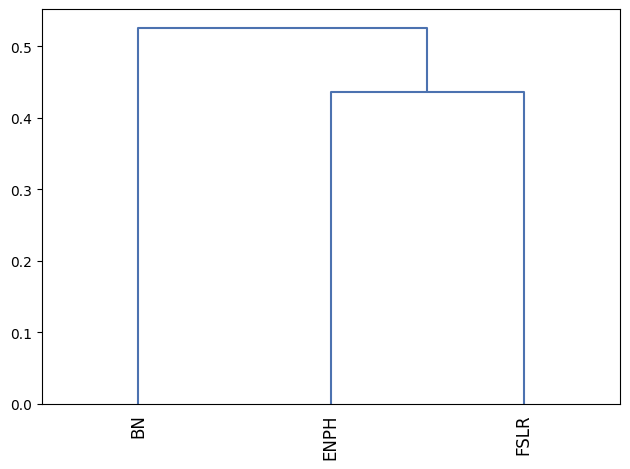

In [93]:
hrp = HRPOpt(daily_returns)
weights = hrp.optimize()
hrp.portfolio_performance(verbose=True)
print(weights)

import pypfopt.plotting as plotting
plotting.plot_dendrogram(hrp)  # to plot dendrogram

OrderedDict([('BN', 0.0), ('ENPH', 0.0), ('FSLR', 1.0)])
Expected annual return: 39.8%
Annual volatility: 52.9%
Sharpe Ratio: 0.71


<Axes: xlabel='Volatility', ylabel='Return'>

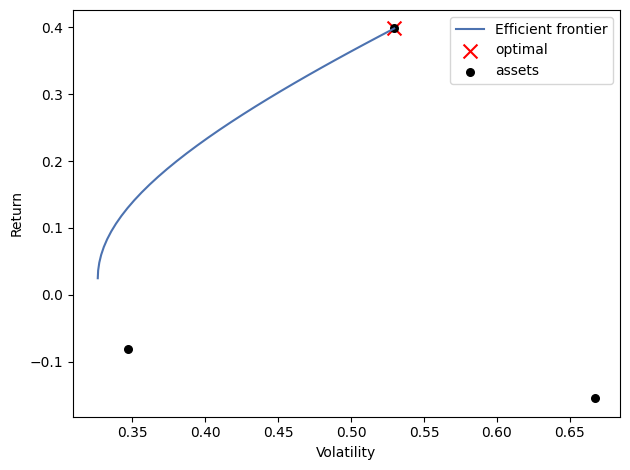

In [94]:
cla = CLA(mu, S)
print(cla.max_sharpe())
cla.portfolio_performance(verbose=True)
plotting.plot_efficient_frontier(cla)  # to plot

# Summary

In [95]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

import universal as up
from universal import tools, algos
from universal.algos import *

sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (16, 8)

ModuleNotFoundError: No module named 'universal'

In [ ]:
# Prepare data for visualizations
'''
model_names = ['Linear Regression', 'Random Forest', 'XGBoost']
company_names = ['Company 1', 'Company 2', 'Company 3']

# Box Plots

for i in range(n_companies):
    plt.figure(figsize=(14, 7))
    data = [predicted_returns[i][model_name] for model_name in model_names]
    plt.boxplot(data, labels=model_names)
    plt.title(f'Box Plot of Predicted Returns for {company_names[i]}')
    plt.ylabel('Expected Return')
    plt.show()

# Line Plots for Actual vs. Predicted Returns
for i, (X_train, X_test, y_train, y_test) in enumerate(data_splits):
    predictions = predicted_returns[i]

    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual Returns', color='blue')
    plt.plot(y_test.index, predictions['Linear Regression'], label='Predicted Returns - Linear Regression', color='red')
    plt.plot(y_test.index, predictions['Random Forest'], label='Predicted Returns - Random Forest', color='green')
    plt.plot(y_test.index, predictions['XGBoost'], label='Predicted Returns - XGBoost', color='orange')
    plt.title(f'Actual vs Predicted Returns for {company_names[i]}')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

# Scatter Plots for Actual vs. Predicted Returns
for i, (X_train, X_test, y_train, y_test) in enumerate(data_splits):
    predictions = predicted_returns[i]

    plt.figure(figsize=(14, 7))
    plt.scatter(y_test, predictions['Linear Regression'], label='Linear Regression', color='red')
    plt.scatter(y_test, predictions['Random Forest'], label='Random Forest', color='green')
    plt.scatter(y_test, predictions['XGBoost'], label='XGBoost', color='orange')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.title(f'Scatter Plot of Actual vs Predicted Returns for {company_names[i]}')
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.show()
'''


Confidence Intervals Matrix (95% CI):
[[[ 0.01450634  0.01450634]
  [ 0.02312538  0.02312538]
  [-0.00217026 -0.00217026]]

 [[ 0.04098992  0.04098992]
  [-0.0720896  -0.0720896 ]
  [ 0.01002199  0.01002199]]

 [[-0.00708762 -0.00708762]
  [-0.01037601 -0.01037601]
  [ 0.02186801  0.02186801]]]


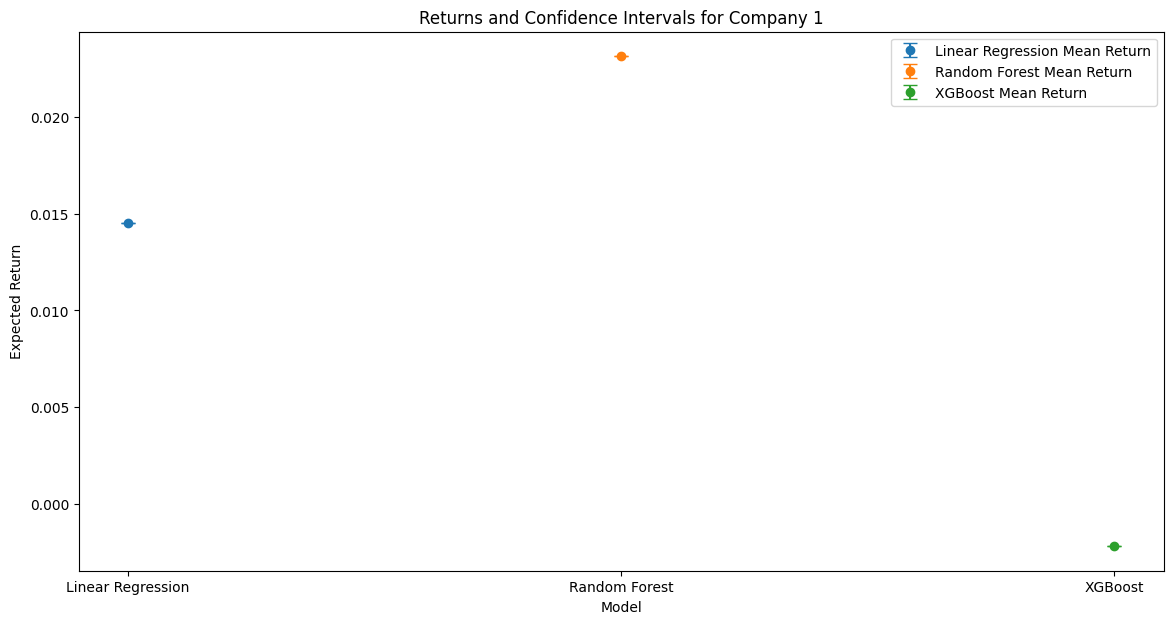

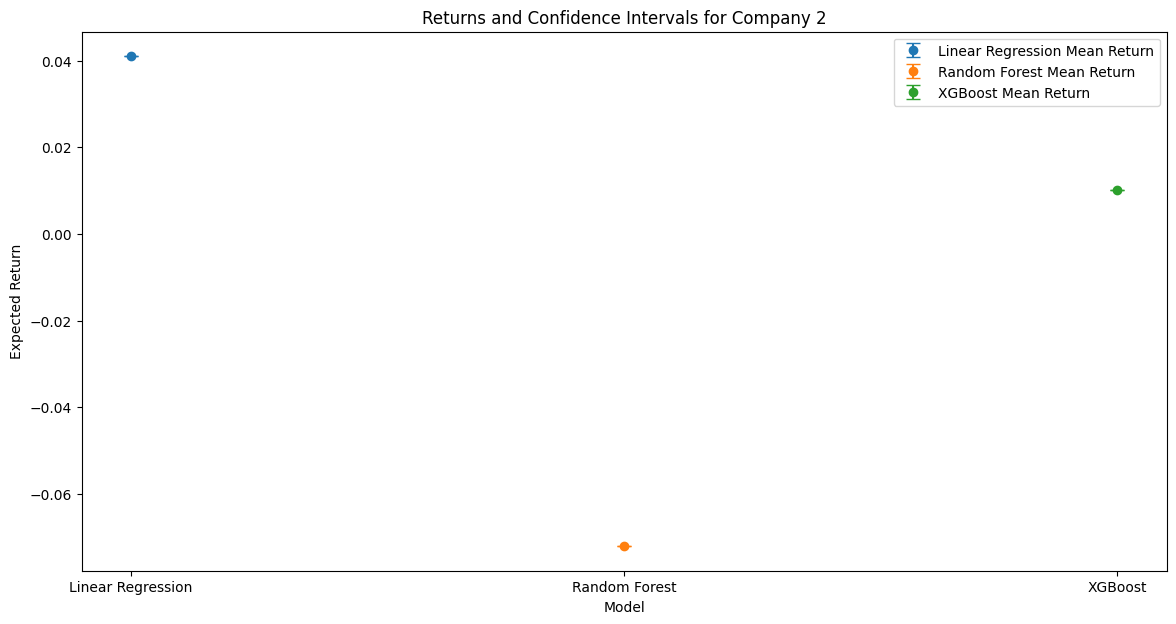

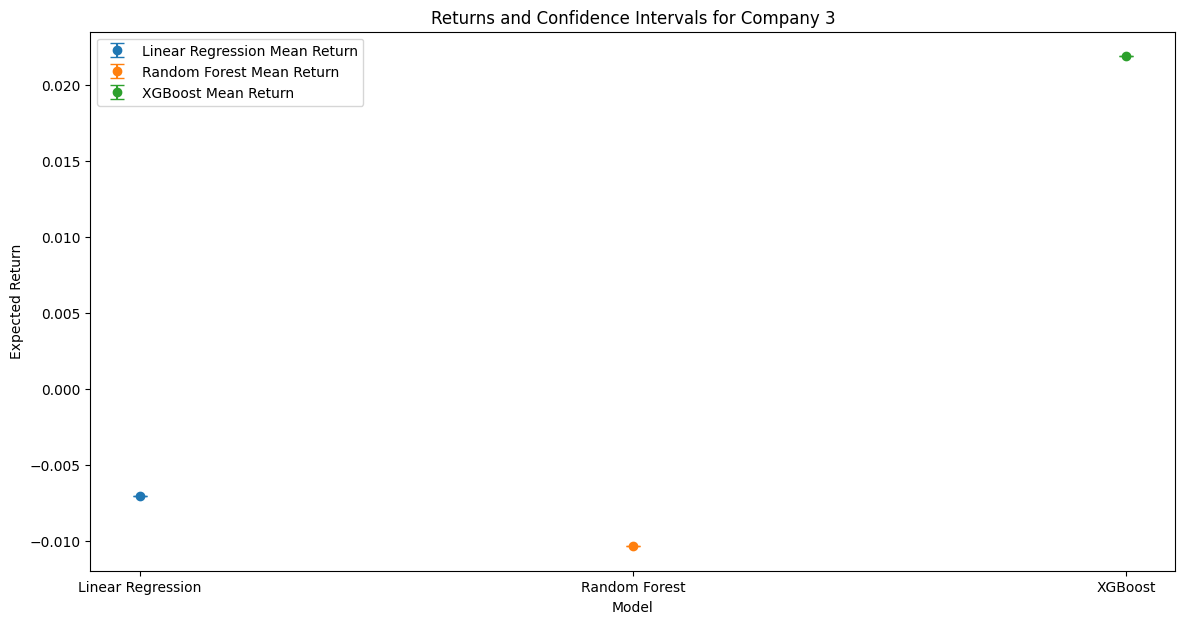

In [17]:

print("\nConfidence Intervals Matrix (95% CI):")
print(confidence_intervals_matrix)

# Prepare data for visualizations
model_names = ['Linear Regression', 'Random Forest', 'XGBoost']
company_names = ['Company 1', 'Company 2', 'Company 3']

# Plot predicted returns with confidence intervals
for i in range(n_companies):
    plt.figure(figsize=(14, 7))
    for j in range(n_models):
        plt.errorbar(j, returns_matrix[i, j],
                     yerr=[[returns_matrix[i, j] - confidence_intervals_matrix[i, j, 0]], [confidence_intervals_matrix[i, j, 1] - returns_matrix[i, j]]],
                     fmt='o', capsize=5, label=f'{model_names[j]} Mean Return')
    plt.title(f'Returns and Confidence Intervals for {company_names[i]}')
    plt.xlabel('Model')
    plt.ylabel('Expected Return')
    plt.xticks(range(n_models), model_names)
    plt.legend()
    plt.show()

<ipython-input-19-3e4eb8a4235a>:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(predicted_returns[i][model_name], label=model_name)


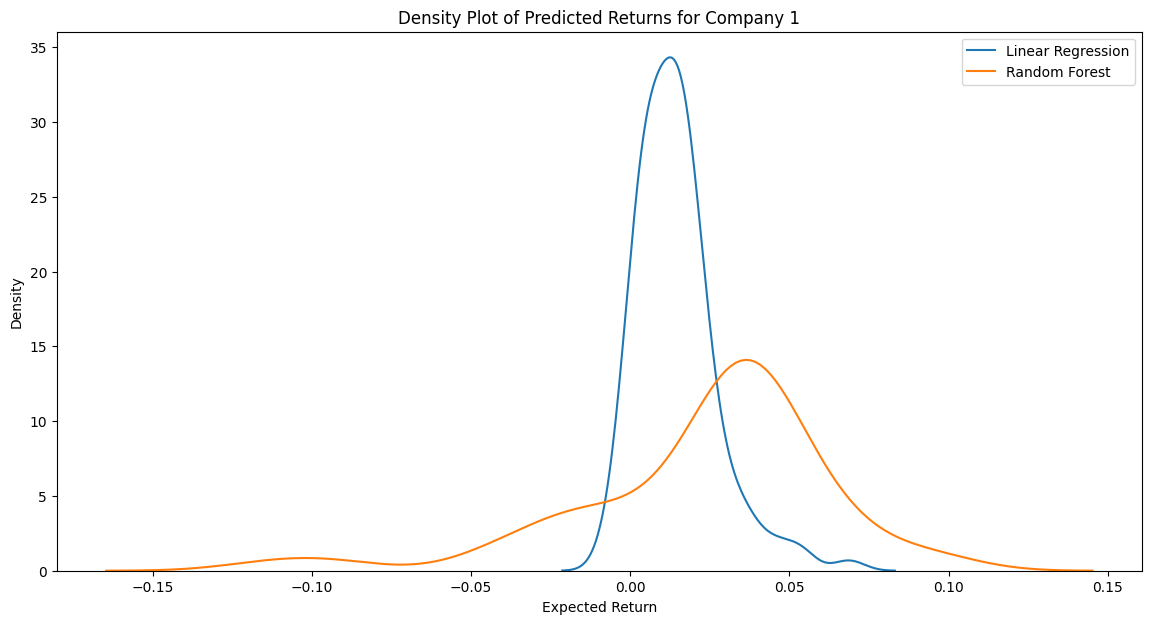

<ipython-input-19-3e4eb8a4235a>:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(predicted_returns[i][model_name], label=model_name)


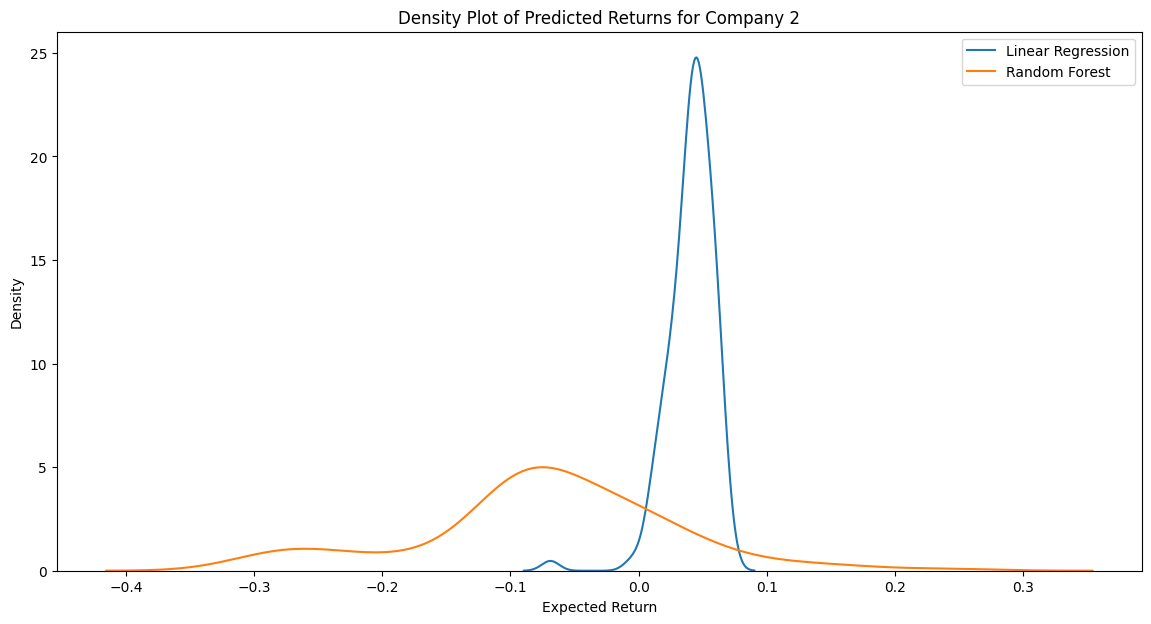

<ipython-input-19-3e4eb8a4235a>:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(predicted_returns[i][model_name], label=model_name)


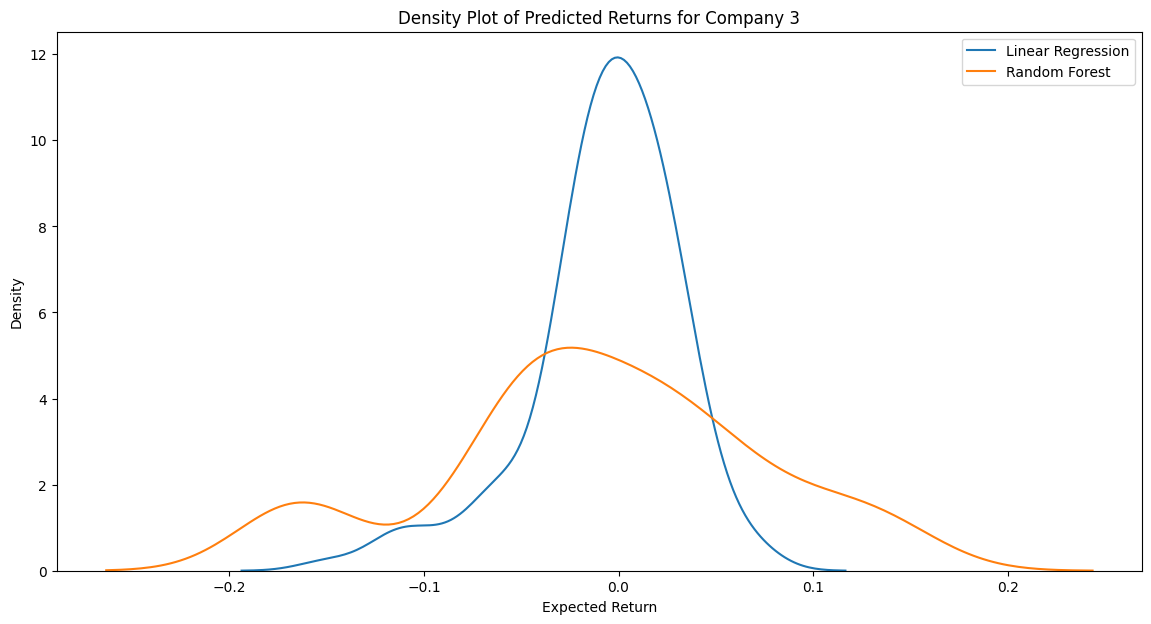

In [19]:
import seaborn as sns

for i in range(n_companies):
    plt.figure(figsize=(14, 7))
    for model_name in model_names:
        sns.kdeplot(predicted_returns[i][model_name], label=model_name)
    plt.title(f'Density Plot of Predicted Returns for {company_names[i]}')
    plt.xlabel('Expected Return')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

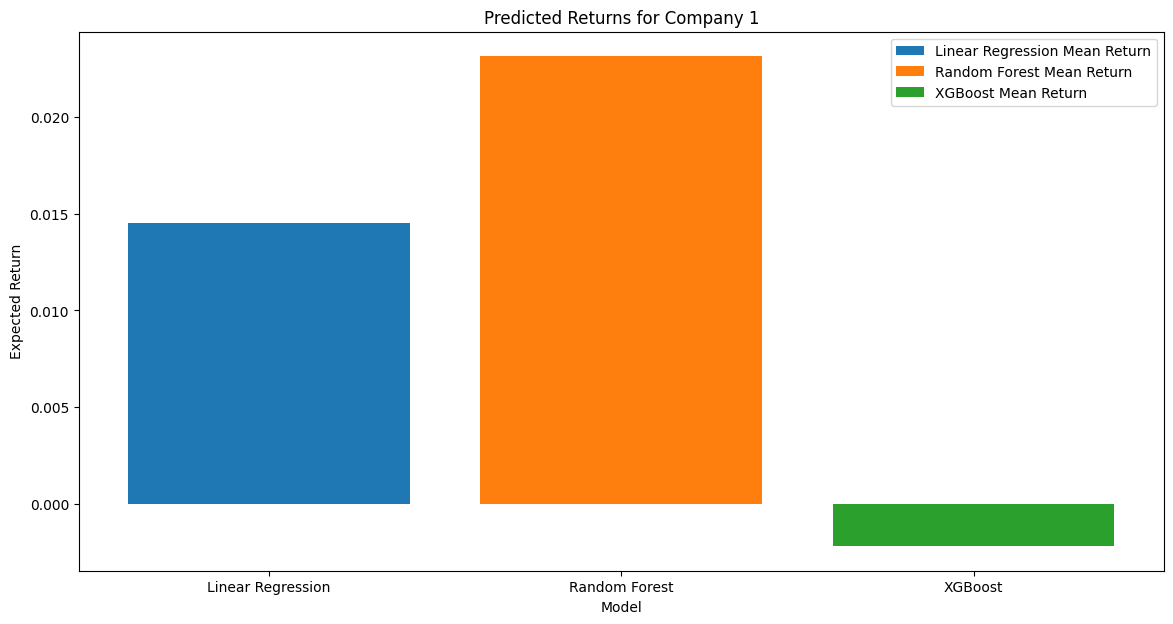

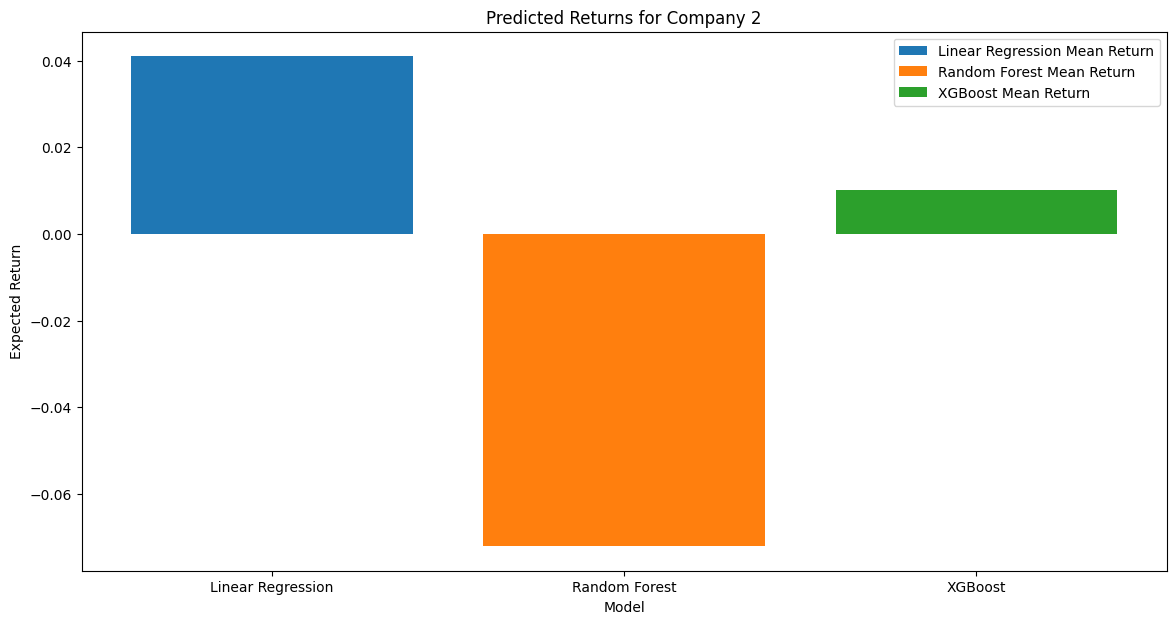

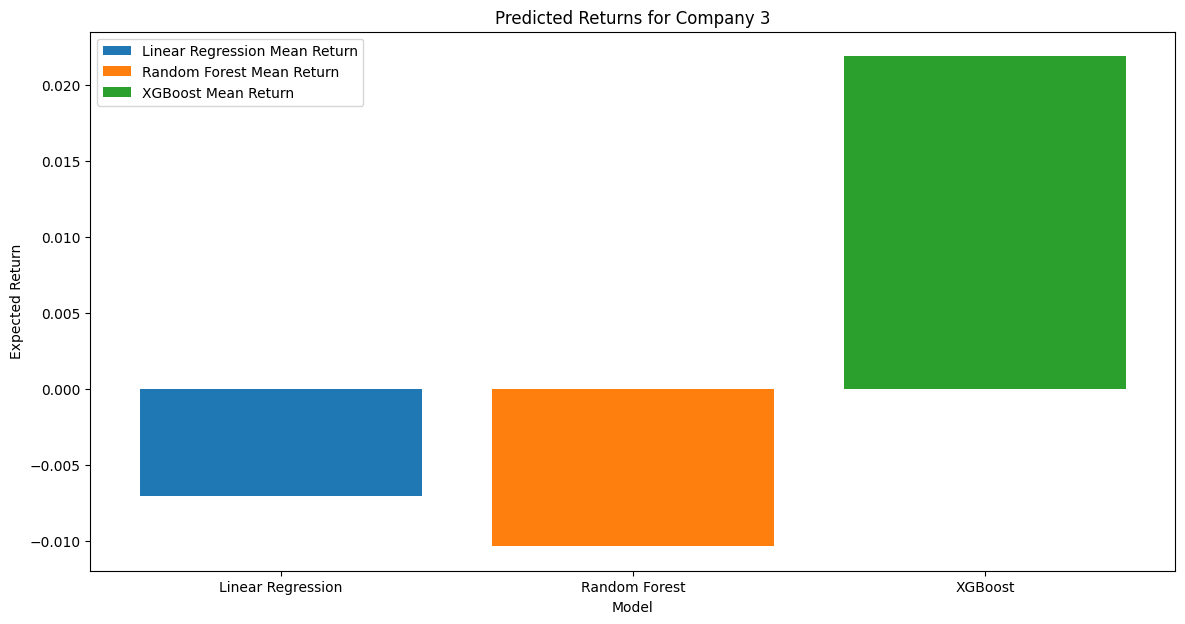

In [13]:
model_names = ['Linear Regression', 'Random Forest', 'XGBoost']
company_names = ['Company 1', 'Company 2', 'Company 3']

for i in range(n_companies):
    plt.figure(figsize=(14, 7))
    for j in range(n_models):
        plt.bar(j, returns_matrix[i, j], label=f'{model_names[j]} Mean Return')
    plt.title(f'Predicted Returns for {company_names[i]}')
    plt.xlabel('Model')
    plt.ylabel('Expected Return')
    plt.xticks(range(n_models), model_names)
    plt.legend()
    plt.show()

TypeError: tuple indices must be integers or slices, not str

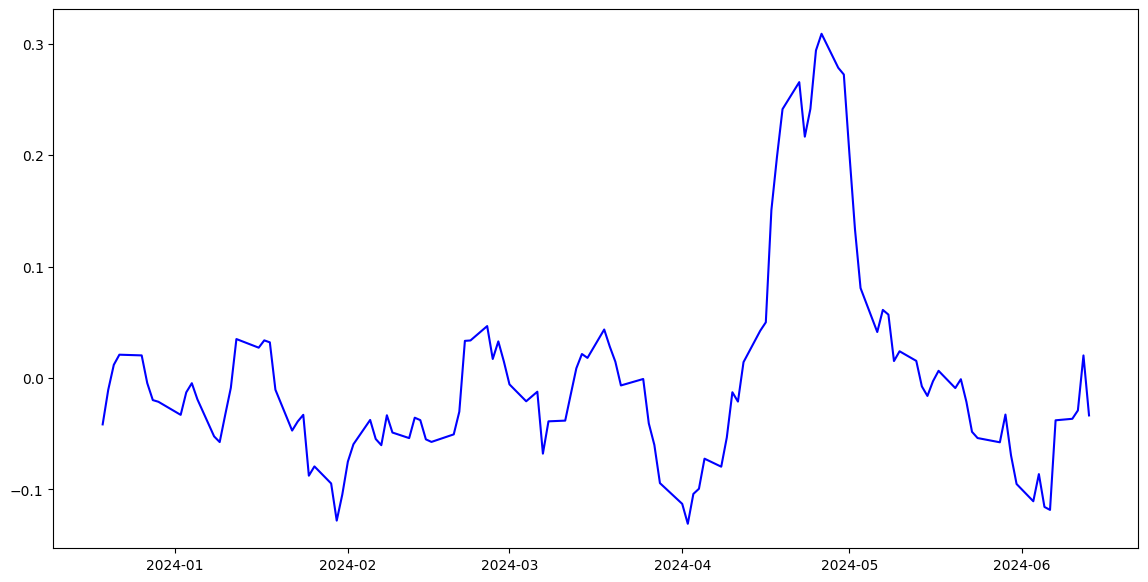

In [14]:
for i, (X_train, X_test, y_train, y_test) in enumerate(data_splits):
    predictions = train_and_predict(X_train, y_train, X_test)

    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual Returns', color='blue')
    plt.plot(y_test.index, predictions['LinearRegression'], label='Predicted Returns - Linear Regression', color='red')
    plt.plot(y_test.index, predictions['RandomForest'], label='Predicted Returns - Random Forest', color='green')
    plt.plot(y_test.index, predictions['XGBoost'], label='Predicted Returns - XGBoost', color='orange')
    plt.title(f'Actual vs Predicted Returns for {company_names[i]}')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()